In [ ]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from scipy import ndimage
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from keras.regularizers import l2
import time

In [ ]:
# Print at least two review from each rating class of the dataset, for a sanity check that labels match the text.
df = pd.read_csv("/content/tripadvisor_hotel_reviews.csv") # please update the location for the file when you run this step. 
df.loc[[15,32,1,10,2,13,0,7,3,4]]

,Review,Rating
15,horrible customer service hotel stay february ...,1
32,"noise airconditioner-a standard, arranged stay...",1
1,ok nothing special charge diamond member hilto...,2
10,"poor value stayed monaco seattle july, nice ho...",2
2,nice rooms not 4* experience hotel monaco seat...,3
13,nice hotel not nice staff hotel lovely staff q...,3
0,nice hotel expensive parking got good deal sta...,4
7,"excellent staff, housekeeping quality hotel ch...",4
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


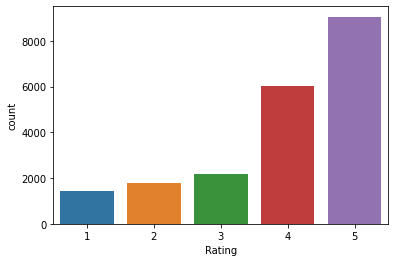

In [ ]:
#Plot a bar graph of class distribution in a dataset. Each bar depicts the number of reviews belonging to a particular rating. (recommended - matplotlib/seaborn libraries)
sns.countplot(x=df["Rating"])

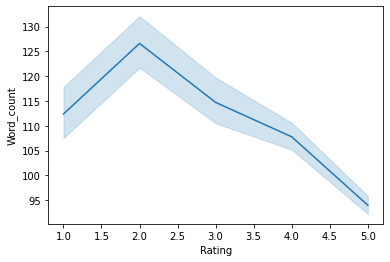

In [ ]:
#Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.
df['Word_count']= df['Review'].map(lambda x: len(x.split()))
sns.lineplot(x='Rating', data=df, y='Word_count')

In [ ]:
#Bring the train and test data in the required format and print the shapes of the train and test data
X,y =  df.Review,df.Rating
X_train, X_test,y_train, y_test= train_test_split(X,y, test_size=0.30, random_state=0)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((14343,), (14343,), (6148,), (6148,))

In [ ]:
#Data Preprocessing : Bring the train and test data in the required format
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
X_train_embed = embed(X_train)
X_test_embed = embed(X_test)


In [ ]:
# Model Building :
# 3 hidden layers - Adding more neurons would increase the training time for the model
# Add L2 regularization
# Added dropout of 40% after layer 2 : Added 40% as it seems to improve the accuracy of the model (20%-40%) seems a be good range. 
# Choose appropriate activaltion function
# Print the model summary
model = tf.keras.models.Sequential([ tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu,  bias_regularizer=l2(0.01)), 
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu, bias_regularizer=l2(0.01)),
                                    tf.keras.layers.Dropout(.4),
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu, bias_regularizer=l2(0.01)),
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu, bias_regularizer=l2(0.01)),
                                    tf.keras.layers.Dense(10, activation = tf.nn.softmax)])
#Learing rate of .001 is chosed as high learing rate give a larger noise and very small will slow down the model reaching the minimum. 
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])
#Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.
# We have considered the train as the validation set for simplicity
tik = time.time()
history=model.fit(X_train_embed, y_train, batch_size=1000, epochs=10,validation_data=(X_test_embed,y_test))
tok = time.time()
model.summary()
print(f"Processing Time = {(tok-tik)} Seconds")

Epoch 1/10
15/15 [==============================] - 9s 560ms/step - loss: 1.4949 - accuracy: 0.3813 - val_loss: 1.1589 - val_accuracy: 0.4746
Epoch 2/10
15/15 [==============================] - 8s 549ms/step - loss: 1.0917 - accuracy: 0.5061 - val_loss: 1.0299 - val_accuracy: 0.5395
Epoch 3/10
15/15 [==============================] - 8s 548ms/step - loss: 1.0064 - accuracy: 0.5477 - val_loss: 0.9974 - val_accuracy: 0.5581
Epoch 4/10
15/15 [==============================] - 8s 548ms/step - loss: 0.9773 - accuracy: 0.5608 - val_loss: 0.9776 - val_accuracy: 0.5716
Epoch 5/10
15/15 [==============================] - 8s 544ms/step - loss: 0.9475 - accuracy: 0.5713 - val_loss: 0.9553 - val_accuracy: 0.5782
Epoch 6/10
15/15 [==============================] - 8s 547ms/step - loss: 0.9285 - accuracy: 0.5861 - val_loss: 0.9865 - val_accuracy: 0.5582
Epoch 7/10
15/15 [==============================] - 8s 547ms/step - loss: 0.9174 - accuracy: 0.5893 - val_loss: 0.9440 - val_accuracy: 0.5786
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


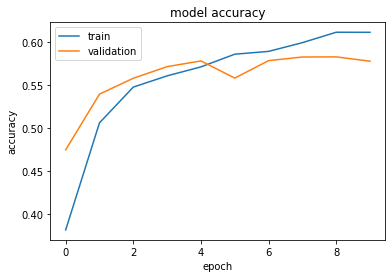

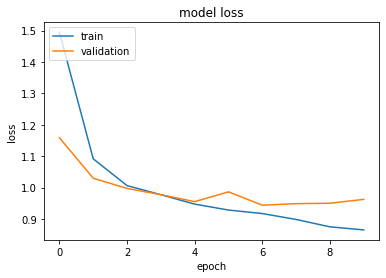

In [ ]:
# Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Predicting for the training set 
y_pred = np.argmax(model.predict(X_test_embed), axis=-1)

In [ ]:
# Evaluating the model
eval_model=model.evaluate(X_train_embed,y_train)

449/449 [==============================] - 5s 12ms/step - loss: 0.8248 - accuracy: 0.6368


In [ ]:
# Printing the confusion matrix and accuracy metrics.
print(f"Loss & Accuracy of the model built : {eval_model}\n")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix\n {cm}")

print(f" Accuracy Score: {accuracy_score(y_test, y_pred)}\n")


Loss & Accuracy of the model built : [0.8247722387313843, 0.6367565989494324]

Confusion Matrix
 [[ 269   93    4   28   11]
 [ 119  232   23  135   27]
 [  25  135   45  430   73]
 [   9   73   20 1086  635]
 [   9   36    3  707 1921]]
 Accuracy Score: 0.5779115159401431



In [ ]:
# printing the classification of the ratings
from sklearn.metrics import classification_report
target_names = ['Rating 1', 'Rating 2', 'Rating 3','Rating 4','Rating 5']
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

    Rating 1       0.62      0.66      0.64       405
    Rating 2       0.41      0.43      0.42       536
    Rating 3       0.47      0.06      0.11       708
    Rating 4       0.46      0.60      0.52      1823
    Rating 5       0.72      0.72      0.72      2676

    accuracy                           0.58      6148
   macro avg       0.54      0.49      0.48      6148
weighted avg       0.58      0.58      0.56      6148



Looking at the above classification report: Ratings 2 and 3 are the two most incorrectl classified text.

In [ ]:
#Hyperparameter training 1: Change the nummber of hidden layers and hidden units for each layer
model = tf.keras.models.Sequential([ tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1000, activation = tf.nn.relu,  bias_regularizer=l2(0.01)), 
                                    tf.keras.layers.Dense(1000, activation = tf.nn.relu, bias_regularizer=l2(0.01)),
                                    tf.keras.layers.Dropout(.4),
                                    tf.keras.layers.Dense(1000, activation = tf.nn.relu, bias_regularizer=l2(0.01)),
                                    tf.keras.layers.Dense(10, activation = tf.nn.softmax)])
#Learing rate of .001 is chosed as high learing rate give a larger noise and very small will slow down the model reaching the minimum. 
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])
#Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.
# We have considered the train as the validation set for simplicity
tik = time.time()
history=model.fit(X_train_embed, y_train, batch_size=1000, epochs=10,validation_data=(X_test_embed,y_test))
tok = time.time()
model.summary()
print(f"Processing Time = {(tok-tik)} Seconds")

Epoch 1/10
15/15 [==============================] - 42s 282ms/step - loss: 1.4280 - accuracy: 0.4318 - val_loss: 1.1640 - val_accuracy: 0.5223
Epoch 2/10
15/15 [==============================] - 4s 271ms/step - loss: 1.0780 - accuracy: 0.5172 - val_loss: 1.0192 - val_accuracy: 0.5384
Epoch 3/10
15/15 [==============================] - 4s 271ms/step - loss: 0.9980 - accuracy: 0.5561 - val_loss: 0.9855 - val_accuracy: 0.5691
Epoch 4/10
15/15 [==============================] - 4s 270ms/step - loss: 0.9594 - accuracy: 0.5769 - val_loss: 0.9694 - val_accuracy: 0.5792
Epoch 5/10
15/15 [==============================] - 4s 272ms/step - loss: 0.9414 - accuracy: 0.5829 - val_loss: 0.9498 - val_accuracy: 0.5794
Epoch 6/10
15/15 [==============================] - 4s 272ms/step - loss: 0.9223 - accuracy: 0.5945 - val_loss: 0.9509 - val_accuracy: 0.5812
Epoch 7/10
15/15 [==============================] - 4s 269ms/step - loss: 0.9117 - accuracy: 0.5959 - val_loss: 0.9686 - val_accuracy: 0.5698
Epoch

Looking at the summary - The accuracy decreased both for training and testing set.

In [ ]:
# Hyperparametr  Tuning : Training the model without Regularization:
model = tf.keras.models.Sequential([ tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu), 
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu),
                                    tf.keras.layers.Dropout(.4),
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(1200, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation = tf.nn.softmax)])
#Learing rate of .001 is chosed as high learing rate give a larger noise and very small will slow down the model reaching the minimum. 
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics =['accuracy'])
#Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.
# We have considered the train as the validation set for simplicity
tik = time.time()
history=model.fit(X_train_embed, y_train, batch_size=1000, epochs=10,validation_data=(X_test_embed,y_test))
tok = time.time()
model.summary()
print(f"Processing Time = {(tok-tik)} Seconds")

Epoch 1/10
15/15 [==============================] - 9s 555ms/step - loss: 1.5299 - accuracy: 0.3928 - val_loss: 1.2135 - val_accuracy: 0.4702
Epoch 2/10
15/15 [==============================] - 8s 541ms/step - loss: 1.0995 - accuracy: 0.5024 - val_loss: 1.0482 - val_accuracy: 0.5342
Epoch 3/10
15/15 [==============================] - 8s 543ms/step - loss: 1.0112 - accuracy: 0.5401 - val_loss: 1.0273 - val_accuracy: 0.5442
Epoch 4/10
15/15 [==============================] - 8s 541ms/step - loss: 0.9822 - accuracy: 0.5608 - val_loss: 0.9901 - val_accuracy: 0.5636
Epoch 5/10
15/15 [==============================] - 8s 540ms/step - loss: 0.9551 - accuracy: 0.5690 - val_loss: 0.9671 - val_accuracy: 0.5667
Epoch 6/10
15/15 [==============================] - 8s 540ms/step - loss: 0.9395 - accuracy: 0.5798 - val_loss: 0.9641 - val_accuracy: 0.5771
Epoch 7/10
15/15 [==============================] - 8s 543ms/step - loss: 0.9231 - accuracy: 0.5856 - val_loss: 0.9555 - val_accuracy: 0.5750
Epoch 

Looking at the summary, the accuracy decreased for both training and testing set